In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import calendar
import sys
sys.path.append('../')  # Add the parent folder to the Python path

from sql_functions import get_dataframe  # Import the function

main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA",
]

side_cities = [
    "Miami, FL",
    "Houston, TX",
    "San Francisco, CA",
    "Seattle, WA"
]


In [2]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE cancellation_code = 'B' 
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''

query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE month = 12 AND cancellation_code = 'B' AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''

query_2017 = '''
	SELECT * 
	FROM group3.flights_2017 
	WHERE (month = 1 OR month = 2)
	AND cancellation_code = 'B' 
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''


flights_2015 = get_dataframe(query_2015)
flights_2017 = get_dataframe(query_2017)
flights_2016 = get_dataframe(query_2016)

In [3]:
# Concatenando os DataFrames de 2016 e dezembro de 2015
flights_2016_2015_2017 = pd.concat([flights_2015, flights_2016, flights_2017], ignore_index=True)

flights_2016_2015_2017["cancelled"] = flights_2016_2015_2017["cancelled"].fillna(1)

In [4]:
# Agrupando os dados por ano e mês e calculando o número de voos cancelados e atrasados
monthly_counts = flights_2016_2015_2017.groupby(['year', 'month']).agg({
    'cancelled': 'sum',
    'had_delay': 'sum'
}).reset_index()

monthly_counts

,year,month,cancelled,had_delay
0,2015,12,193,3
1,2016,1,867,1
2,2016,2,422,5
3,2016,3,84,2
4,2016,4,69,0
5,2016,5,75,4
6,2016,6,141,5
7,2016,7,442,10
8,2016,8,173,7
9,2016,9,40,1


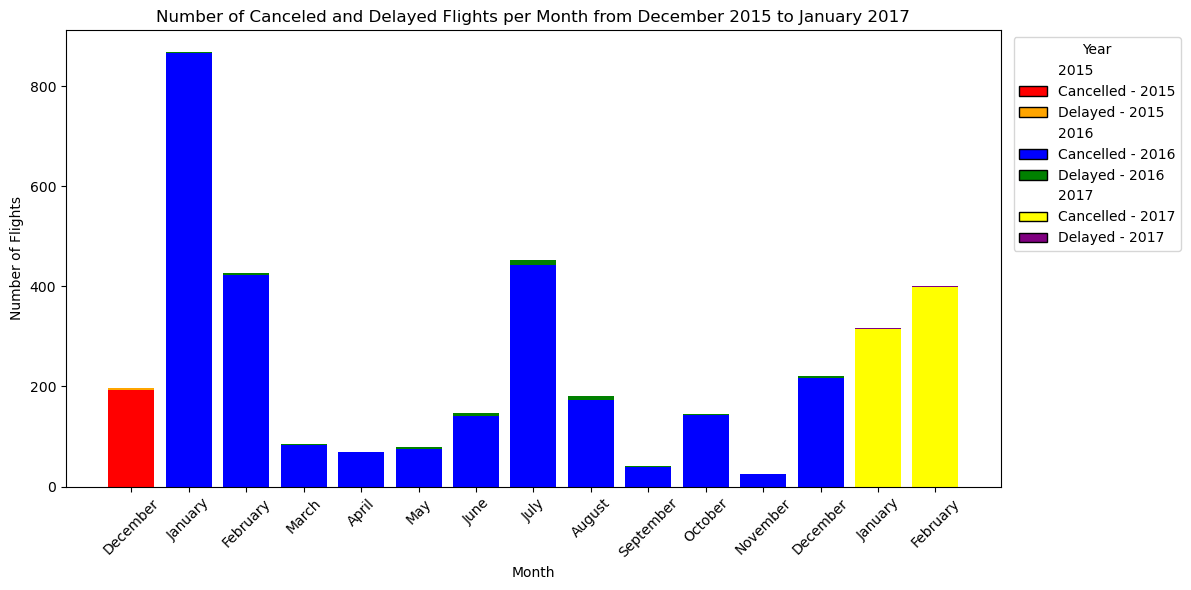

In [5]:
# Mapping month numbers to month names
monthly_counts['month_name'] = monthly_counts['month'].apply(lambda x: calendar.month_name[x])


# Plotting the bar chart
plt.figure(figsize=(12, 6))


# Loop through each row in the DataFrame and plot bars
for index, row in monthly_counts.iterrows():
    year = row['year']
    color_cancelled = 'red' if year == 2015 else ('blue' if year == 2016 else 'yellow')
    color_delay = 'orange' if year == 2015 else ('green' if year == 2016 else 'purple')
    hatch = '\\' if year in [2015, 2016] else None
    plt.bar(index, row['cancelled'], color=color_cancelled, label=f'Cancelled - {year}')
    plt.bar(index, row['had_delay'], bottom=row['cancelled'], color=color_delay, label=f'Delayed - {year}')

# Adding legend for all years
legend_elements = [
    Patch(facecolor='none', edgecolor='none', label='2015'),  # Title for 2015
    Patch(facecolor='red', edgecolor='black', label='Cancelled - 2015'),
    Patch(facecolor='orange', edgecolor='black', label='Delayed - 2015'),
    Patch(facecolor='none', edgecolor='none', label='2016'),  # Title for 2016
    Patch(facecolor='blue', edgecolor='black', label='Cancelled - 2016'),
    Patch(facecolor='green', edgecolor='black', label='Delayed - 2016'),
    Patch(facecolor='none', edgecolor='none', label='2017'),  # Title for 2017
    Patch(facecolor='yellow', edgecolor='black', label='Cancelled - 2017'),
    Patch(facecolor='purple', edgecolor='black', label='Delayed - 2017')
]

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1), title='Year')  # Adding legend with titles

plt.title('Number of Canceled and Delayed Flights per Month from December 2015 to January 2017')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(len(monthly_counts)), monthly_counts['month_name'], rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Assuming monthly_counts is a DataFrame
sum_cancelled_1 = monthly_counts.iloc[13::]["cancelled"].sum()
sum_cancelled_1 / 2


correlation = monthly_counts['cancelled'].corr(monthly_counts['month'])

print("Correlation coefficient between Column cancelled and Column month:", correlation)

Correlation coefficient between Column cancelled and Column month: -0.5088879526301328


### Check the city among the main cities that were more affected

In [7]:
new_2016 = (flights_2016[(flights_2016["month"] == 1) | (flights_2016["month"] == 2)]).copy()


In [8]:
# Group by main city and month, counting the cancelled flights
new_2016_grouped = new_2016.groupby(['month', 'main_city']).size().unstack(fill_value=0)

# Map the numeric month values to month names using calendar
new_2016_grouped.index = new_2016_grouped.index.map(lambda x: calendar.month_name[x])

# Plotting
new_2016_grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Cancelled Flights in Main Cities (2016)')
plt.xlabel('Month')
plt.ylabel('Number of Cancelled Flights')
plt.xticks(rotation=45)  # No need for custom tick positions and labels
plt.legend(title='Main City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyError: 'main_city'

In [ ]:
new_2016 = (flights_2016[(flights_2016["month"] == 1) | (flights_2016["month"] == 2)]).copy()

# Group by main city and month, counting the cancelled flights
new_2016_grouped = new_2016.groupby(['month', 'main_city']).size().unstack(fill_value=0)

# Map the numeric month values to month names using calendar
new_2016_grouped.index = new_2016_grouped.index.map(lambda x: calendar.month_name[x])

# Plotting
new_2016_grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Cancelled Flights in Main Cities (2016)')
plt.xlabel('Month')
plt.ylabel('Number of Cancelled Flights')
plt.xticks(rotation=45)  # No need for custom tick positions and labels
plt.legend(title='Main City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Comparing dates and cancelled flights per month

In [ ]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE (month = 1 OR month = 2 OR month = 12)
	AND cancellation_code = 'B' 
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		)
	);
'''

query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE cancellation_code = 'B'
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		)
	);
'''

query_2017 = '''
	SELECT * 
	FROM group3.flights_2017 
	WHERE cancellation_code = 'B' 
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Boston, MA',
			'Philadelphia, PA'
		)
	);
'''


flights_2015_months = get_dataframe(query_2015)
flights_2017_months = get_dataframe(query_2017)
flights_2016_months = get_dataframe(query_2016)

flights_2015_months['cancelled'] = flights_2015_months['cancelled'].astype(int)
flights_2016_months['cancelled'] = flights_2015_months['cancelled'].astype(int)
flights_2017_months['cancelled'] = flights_2015_months['cancelled'].astype(int)


In [ ]:
first_winter = pd.concat([flights_2015_months[flights_2015_months["month"].isin([12])],
                          flights_2016_months[flights_2016_months["month"].isin([1, 2])]])

In [ ]:
# Grouping data by date and counting cancelled flights
cancelled_per_day = first_winter.groupby('flight_date')['cancelled'].sum()

# Plotting
plt.figure(figsize=(10, 6))
cancelled_per_day.plot(kind='line', marker='o', color='red')
plt.title('Cancelled Flights per Day')
plt.xlabel('Date')
plt.ylabel('Number of Cancelled Flights')
plt.grid(True)
plt.show()

In [ ]:
second_winter = pd.concat([flights_2016_months[flights_2016_months["month"].isin([12])],
                          flights_2017_months[flights_2017_months["month"].isin([1, 2])]])


# Grouping data by date and counting cancelled flights
cancelled_per_day = second_winter.groupby('flight_date')['cancelled'].sum()

# Plotting
plt.figure(figsize=(10, 6))
cancelled_per_day.plot(kind='line', marker='o', color='red')
plt.title('Second Winter(December 2015 - February 2016): Cancelled Flights per Day')
# Adding subtitle
plt.suptitle('Subtitle: Sales Performance Analysis', y=1.02, fontsize=12)
plt.xlabel('Date')
plt.ylabel('Number of Cancelled Flights')
plt.grid(True)
plt.show()

In [ ]:
#flights_2016_2015_2017_months = pd.concat([flights_2015_months, flights_2016_months, flights_2017_months], ignore_index=True)
#flights_2016_2015_2017_months.drop(columns=["origin", "destination", "diverted", "had_delay", "dep_delay", "arr_delay"], inplace=True)
#flights_2016_2015_2017_months.sample(20)